In [1]:
import json
import requests
import numpy as np
import os, sys
from collections import Counter, defaultdict
import math
import datetime
import sqlite3

In [2]:
print(os.getcwd())
sys.path.insert(0, str(os.path.dirname(os.path.realpath(os.getcwd()))))
print(sys.path)

/mnt/raidbio/extproj/projekte/textmining/miRExplore/python/nbs
['/mnt/raidbio/extproj/projekte/textmining/miRExplore/python', '/mnt/raidbio/extproj/projekte/textmining/miRExplore/python/nbs', '/mnt/extproj/projekte/bartelt/software/miniconda3/envs/mirexplore/lib/python36.zip', '/mnt/extproj/projekte/bartelt/software/miniconda3/envs/mirexplore/lib/python3.6', '/mnt/extproj/projekte/bartelt/software/miniconda3/envs/mirexplore/lib/python3.6/lib-dynload', '', '/home/j/joppich/.local/lib/python3.6/site-packages', '/mnt/extproj/projekte/bartelt/software/miniconda3/envs/mirexplore/lib/python3.6/site-packages', '/mnt/extproj/projekte/bartelt/software/miniconda3/envs/mirexplore/lib/python3.6/site-packages/IPython/extensions', '/home/j/joppich/.ipython']


In [3]:
from textdb.PubmedDateDB import PubmedDateDB
from synonymes.mirnaID import miRNA, miRNAPART,miRNACOMPARISONLEVEL
from textdb.MiGenRelDB import MiGenRelDB

from synonymes.GeneOntology import GeneOntology

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.stats import hypergeom
#from statsmodels.stats.multitest import multipletests



In [4]:
oboFolder = "/mnt/raidbio/extproj/projekte/textmining/obodir/"

infodict2obo = {}
infodict2obo["celllines"] = GeneOntology(oboFolder + "/cell_ontology.obo")
infodict2obo["disease"] = GeneOntology(oboFolder + "/doid.obo")
infodict2obo["GeneOntology"] = GeneOntology(oboFolder + "/go.obo")

0
no parent 194
0
10000
no parent 2482
0
10000
20000
30000
40000
no parent 5290


In [5]:
con =  sqlite3.connect('/mnt/extproj/projekte/textmining/mx_frontend/cons_evidences.db')
cur = con.cursor()

In [99]:
def get_relation_data(cursor, mirna, gene):
    
    if mirna and gene:
        sqlres = cursor.execute("""
                    SELECT miRNA_family, gene_family, interaction, evidence_documents FROM mx WHERE miRNA_family='{}' and gene_family='{}'
                    ORDER BY evidence_count desc;
                    """.format(mirna, gene)
                    )
    else:
        if mirna:
            query_equal = "miRNA_family='{}'".format(mirna)
        else:
            query_equal = "gene_family='{}'".format(gene)
        
        sqlres = cursor.execute("""
                SELECT miRNA_family, gene_family, interaction, evidence_documents FROM mx WHERE {}
                ORDER BY evidence_count desc;
                """.format(query_equal)
                )
    
    results = []
    for x in sqlres:
        results.append({
            "miRNA_family": x[0],
            "gene_family": x[1],
            "interaction": x[2],
            "evidence_documents": x[3],
        })
    return results
        

In [144]:
def get_doc_pubdates(cursor, documents):
    
    query = """
    SELECT doc_id, date FROM mx_dates WHERE doc_id IN ({});
    """.format(",".join(["'{}'".format(x) for x in documents]))
    
    sqlres = cursor.execute(query)
    
    results = {}
    for x in sqlres:
        results[x[0]] = datetime.datetime.strptime(x[1], '%Y-%m-%d')

    return results
        

In [12]:
def get_annot_data(cursor, documents, rel_annotations=['celllines', 'disease', 'GeneOntology']):
    sqlres = cursor.execute("""
                SELECT doc_id, annotation, concept_id, concept FROM mx_annot WHERE doc_id IN ({}) and annotation IN ({});
                """.format(",".join(["'{}'".format(x) for x in documents]), ",".join(["'{}'".format(x) for x in rel_annotations]))
                )
    
    results = []
    for x in sqlres:
        results.append({
            "doc_id": x[0],
            "annotation": x[1],
            "concept_id": x[2],
            "concept": x[3],
        })
    return results
        

In [13]:
get_annot_data(cur, ["26045772", "26126865"])[:5]

[{'doc_id': '26045772',
  'annotation': 'GeneOntology',
  'concept_id': 'GO:0006954',
  'concept': 'inflammatory response'},
 {'doc_id': '26126865',
  'annotation': 'GeneOntology',
  'concept_id': 'GO:0019835',
  'concept': 'cytolysis'},
 {'doc_id': '26126865',
  'annotation': 'GeneOntology',
  'concept_id': 'GO:0008219',
  'concept': 'cell death'},
 {'doc_id': '26045772',
  'annotation': 'GeneOntology',
  'concept_id': 'GO:0009058',
  'concept': 'biosynthetic process'},
 {'doc_id': '26045772',
  'annotation': 'disease',
  'concept_id': 'DOID:3627',
  'concept': 'aortic aneurysm'}]

In [ ]:
for x in cur.execute("SELECT doc_id, annotation, concept_id, concept FROM mx_annot WHERE doc_id = '26045772';"):
    print(x)

In [114]:
for x in cur.execute("SELECT * FROM mx_dates WHERE doc_id = '28425867';"):
    print(x)


(22214, '28425867', '2018-01-01')


In [152]:
def make_timeline( allInteractions, title, outpath=None ):

    allInteractions = sorted(allInteractions, key=lambda x: x["date"])
    
    names = []
    dates = []

    for x in allInteractions:
        
        ctx_string = ""
        for ctx in x["context"]:
            for elem in x["context"][ctx]:
                ctx_string += "{} ({})\n".format(elem[0], elem[1])
            ctx_string += "\n"
        pmidDesc = x["interaction"] + "\n" + "{}, {}".format(x["doc_id"], x["date"].strftime("%B %Y")) + "\n" + ctx_string + "\n"
        date = x["date"]

        names.append(pmidDesc)
        dates.append(date)
        
    alllevels = [-5,5,-1,1] #-3,3,
        
    # Choose some nice levels
    levels = np.tile(alllevels,
                     int(np.ceil(len(dates)/len(alllevels))))[:len(dates)]
    
    szFac = len(names) // 15
    szFac += 1

    # Create figure and plot a stem plot with the date
    fig, ax = plt.subplots(figsize=(szFac * 15, 15), constrained_layout=True)
    ax.set(title=title)

    markerline, stemline, baseline = ax.stem(dates, levels,
                                             linefmt="C3-", basefmt="k-",
                                             use_line_collection=True)

    plt.setp(markerline, mec="k", mfc="w", zorder=3)

    # Shift the markers to the baseline by replacing the y-data by zeros.
    markerline.set_ydata(np.zeros(len(dates)))

    # annotate lines
    vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
    for d, l, ltext, va in zip(dates, levels, names, vert):
        ax.annotate(ltext, xy=(d, l+ (-1) * np.sign(l) * 0.75), xytext=(-10, np.sign(l)*4),
                    textcoords="offset points", va=va, ha="right")

    # format xaxis with 4 month intervals
    ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=6))
    ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

    # remove y axis and spines
    ax.get_yaxis().set_visible(False)
    for spine in ["left", "top", "right"]:
        ax.spines[spine].set_visible(False)

    ax.margins(y=0.1)
    
def vis_interaction( mir, gene, interactions):
    
    if len(interactions) == 1:
        relInteract, relCategory = list(interactions.keys())[0].split(";")
    else:
        relIC, relCount = interactions.most_common(1)[0]
        relInteract, relCategory = relIC.split(";")

    if relInteract == "MIR_GENE":
        e1 = mir
        e2 = gene               
    else:
        e1 = gene
        e2 = mir
     
    if relCategory in ["DOWN"]:
        e12c = u"\u22a3"
    elif relCategory in ["UP"]:
        e12c = u"\u2191"
    elif relCategory in ["NEU"]:
        e12c = u"\u21e5"
    elif relCategory in ["NA"]:

        e12c = u"\u2974"
        e12c = u"\u1e6a"
        
    return "{} {} {}".format(e1, e12c, e2)



def get_doc_contexts(cursor, doc_ids, context_obos, printable=True):
    
    res = get_annot_data(cur, doc_ids)
    
    result = defaultdict(lambda: defaultdict(Counter))
    for x in res:
        docid = x["doc_id"]
        ctx_type = x["annotation"]
        concept = (x["concept"], x["concept_id"])
        
        result[docid][ctx_type][concept] += 1
        
    if not printable:
        return result
        
    for doc_id in result:
        for context in result[doc_id]:
            
            if not context in context_obos:
                continue
            obo = context_obos[context]
            
            parents = []
            for concept, concept_id in result[doc_id][context]:
                
                conceptParents = obo[concept_id].get_parents()
                if conceptParents is None:
                    continue
                
                for parent in conceptParents:
                    parents.append((obo[parent.termid].name, parent.termid))
            
            for parent in parents:
                result[doc_id][context][parent] += 2
                       
                       
    print_results = defaultdict(lambda: defaultdict(list))
    for doc_id in result:
        for context in result[doc_id]:
            for elem, _ in result[doc_id][context].most_common(2):
                
                elem_name, elem_id = elem
                if len(elem_name) > 25:
                    elem_name = elem_name[:17] + " ..."
                
                print_results[doc_id][context].append( (elem_name, elem_id) )
                
                                                
    return print_results



In [142]:
def get_doc_with_contexts(cursor, relevant_documents, context, obodict):
   
     
    context2terms = defaultdict(set)
    for ctx in context:
        for term in context[ctx]:
            context2terms[ctx].update([term["termid"]]+[x.termid for x in obodict[ctx][term["termid"]].getAllChildren()])
            
               
    doc_contexts = get_doc_contexts(cursor, relevant_documents, obodict, printable=False)
    
    accepted_documents = set()

    for doc_id in doc_contexts:
        accepted_contexts = 0
        for ctx in context:
            doc_terms = [x[1] for x in doc_contexts[doc_id][ctx]]
            
            if len(context2terms[ctx].intersection(doc_terms)) > 0:
                accepted_contexts += 1
                
        if accepted_contexts == len(context):
            accepted_documents.add(doc_id)
    
    return accepted_documents


In [104]:
#infodict2obo["GeneOntology"]["GO:0061000"].getAllChildren()

In [148]:
def generateInteractionHistory( cursor, gene, mir, title="", obodict={}, context=None):
    
    mir_gene_interactions = get_relation_data(cursor, mir, gene)
    
    relevant_documents = set()
    doc2interactions = defaultdict(Counter)
    
    for x in mir_gene_interactions:
        for doc in x["evidence_documents"].split(";"):
            relevant_documents.add(doc)
            doc2interactions[doc][x["interaction"]] += 1
    #
    ## filter for documents one is interested in
    #
    if not context is None:
        relevant_documents = get_doc_with_contexts(cursor, relevant_documents, context, obodict)
    
    contexts = get_doc_contexts(cursor, relevant_documents, obodict)
    
    docDates = get_doc_pubdates(cursor, relevant_documents)
    
    print_entries = []
    for entry in mir_gene_interactions:
        for doc_id in entry["evidence_documents"].split(";"):
            
            if not doc_id in relevant_documents:
                continue
            
            doc_entry = {}
            doc_entry["interaction"] = vis_interaction(entry["miRNA_family"], entry["gene_family"], doc2interactions[doc_id])

            doc_entry["doc_id"] = doc_id
            
            if not doc_id in docDates:
                print(doc_id)
            
            doc_entry["date"] = docDates[doc_id]
            doc_entry["context"] = contexts[doc_id]
            
            print_entries.append(doc_entry)

    if len(print_entries):
        make_timeline( print_entries, title, outpath=None )
    



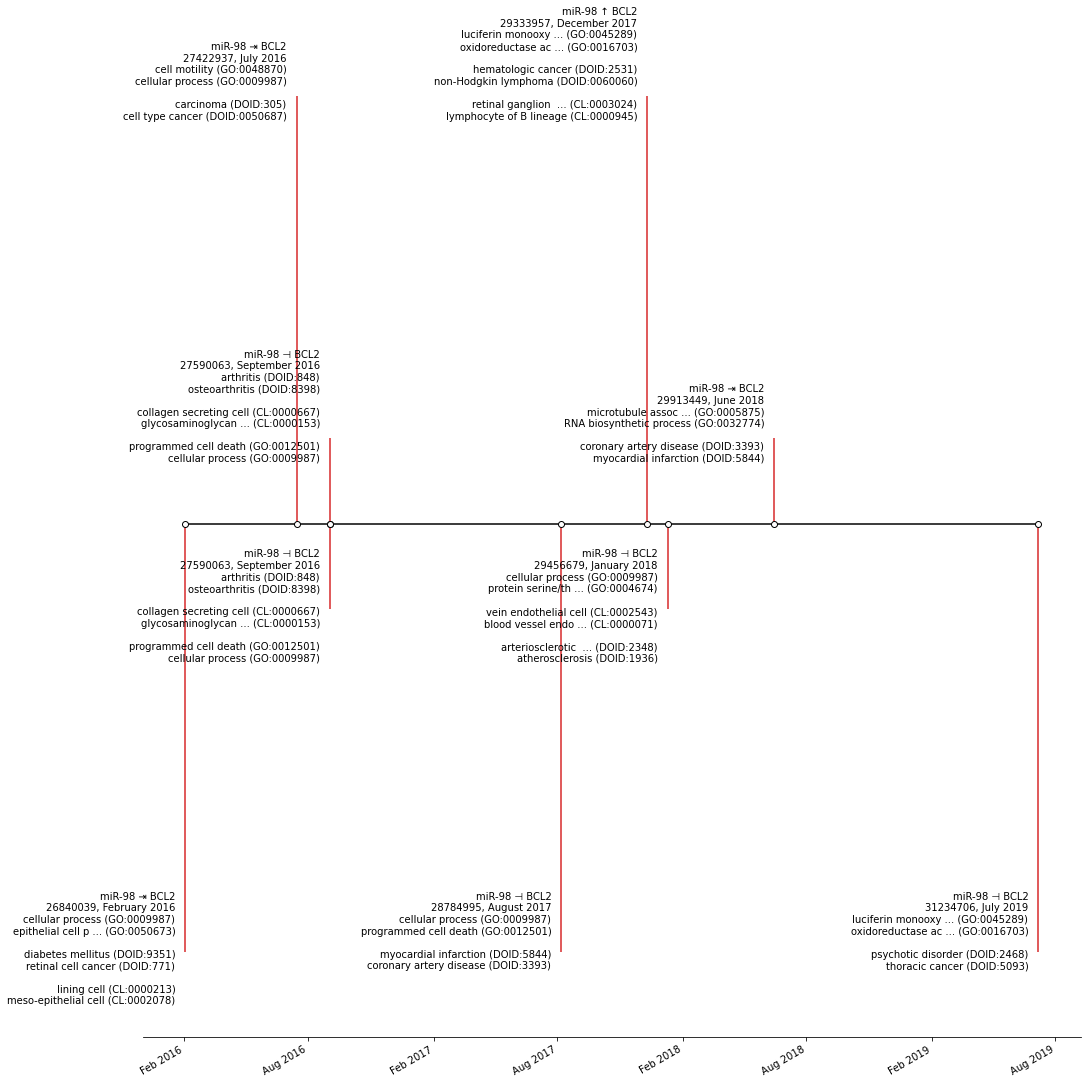

In [153]:
generateInteractionHistory(cursor=cur, gene="BCL2", mir="miR-98", obodict=infodict2obo)

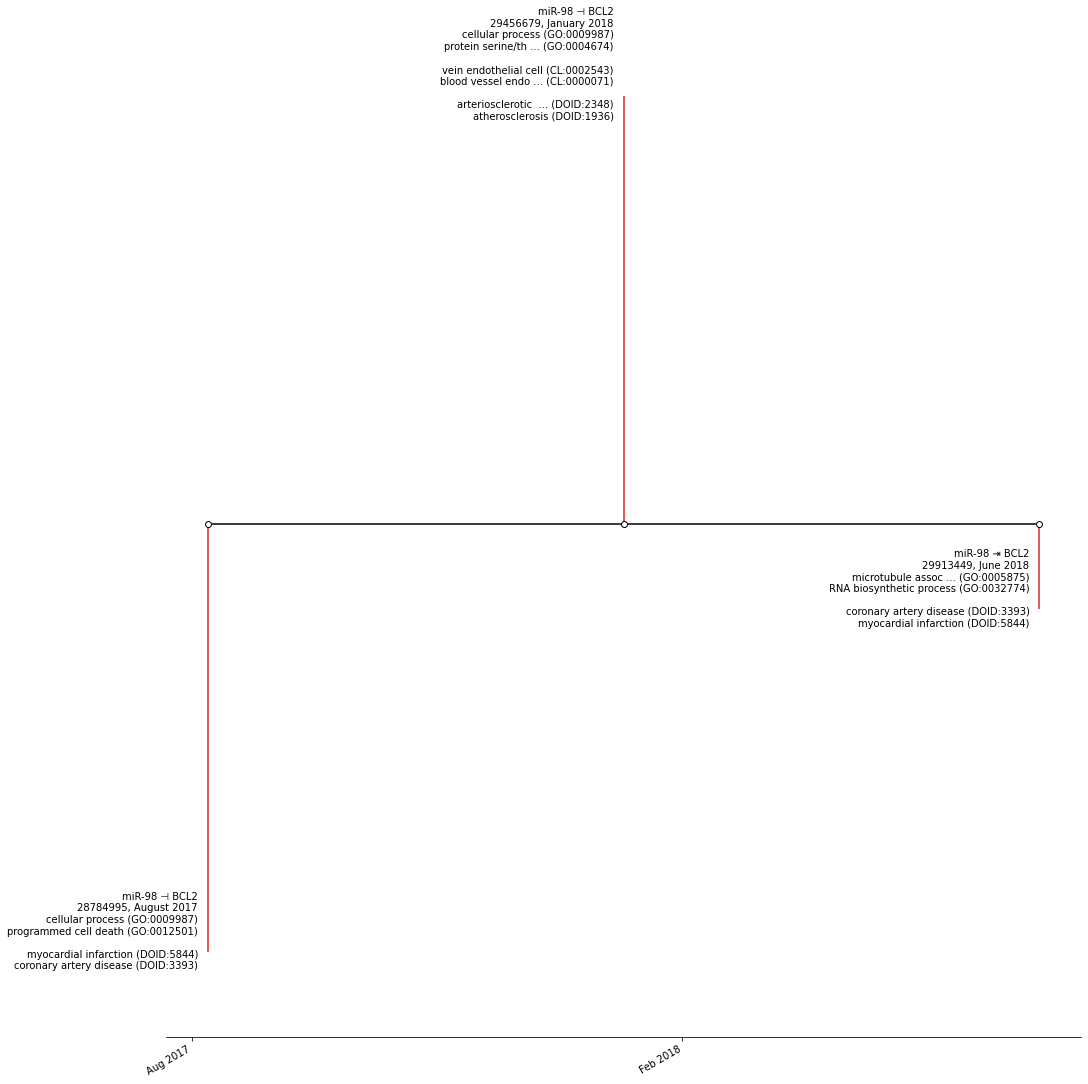

In [154]:
generateInteractionHistory(cursor=cur, gene="BCL2", mir="miR-98", context={'disease': [{'termid': "DOID:1287"}]}, obodict=infodict2obo)

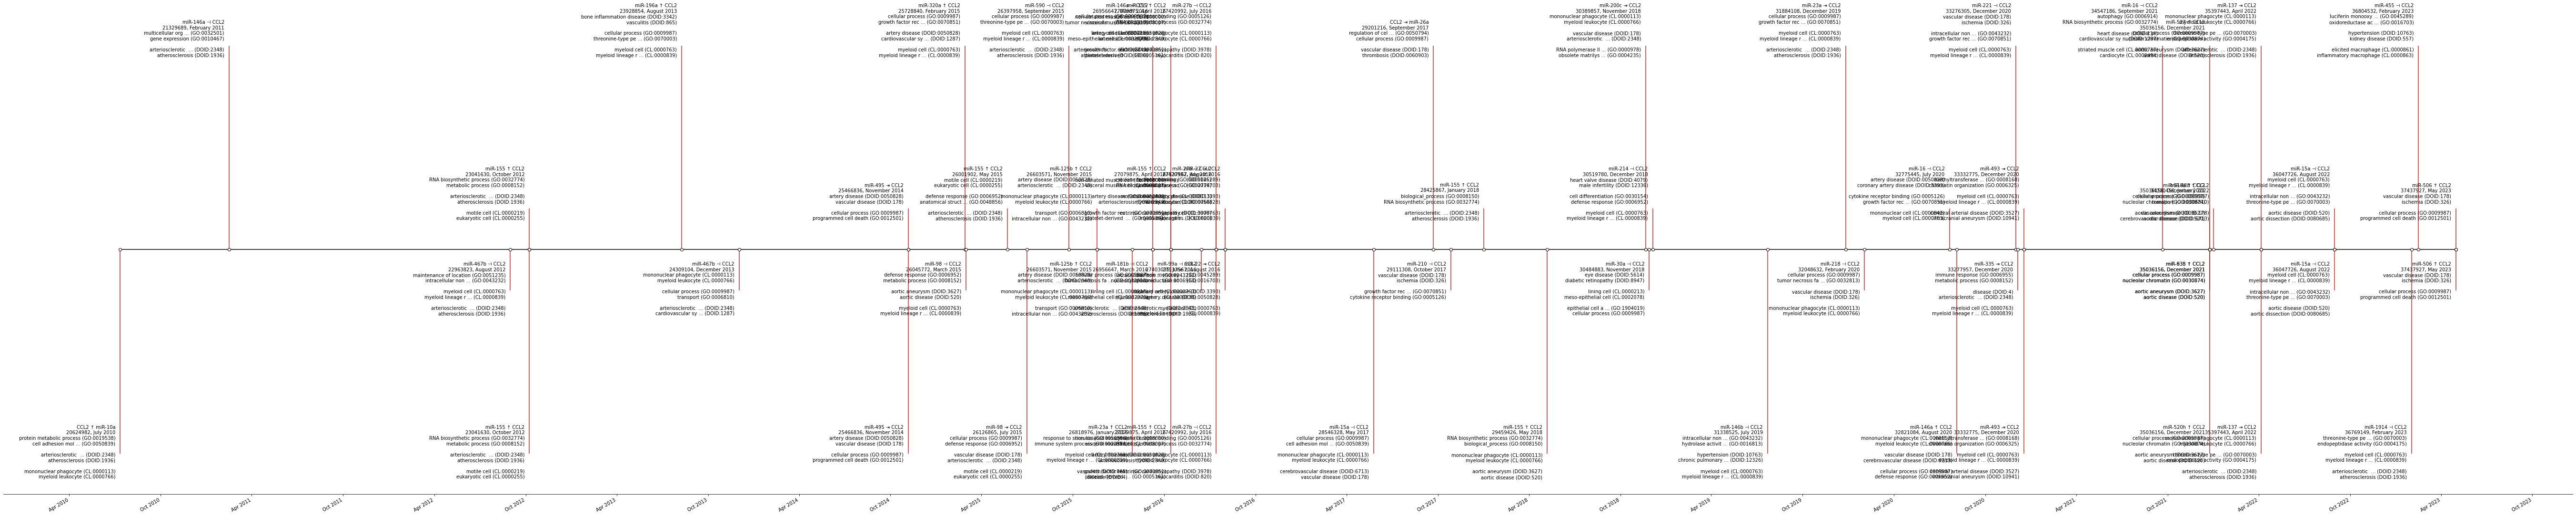

In [155]:
generateInteractionHistory(cursor=cur, gene="CCL2", mir=None, context={'disease': [{'termid': "DOID:1287"}]}, obodict=infodict2obo)

In [ ]:
generateInteractionHistory(gene="CCL2", mir=None, context={'disease': [{'termid': "DOID:1287"}]}, obodict=infodict2obo)
plt.savefig("ccl2_athero.png")